In [1]:
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pickle
import os
import sys
from numpy import random
import time
import pandas as pd

# Add QDYN directory to PATH
sys.path.append('/Users/elifo/Desktop/2023_Cycles/qdyn-read-only/src')  # For pyqdyn
sys.path.append('/Users/elifo/Desktop/2023_Cycles/qdyn-read-only/utils/post_processing') # For plot_functions
print(sys.path)
from pyqdyn import qdyn
import plot_functions as qdyn_plot

['/Users/elifo/Desktop/2023_Cycles/qdyn-read-only/examples/elif/40L_damage', '/Users/elifo/Python/Progs', '/Users/elifo/opt/anaconda3/lib/python38.zip', '/Users/elifo/opt/anaconda3/lib/python3.8', '/Users/elifo/opt/anaconda3/lib/python3.8/lib-dynload', '', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/smtk-0.9.0_gite2e537d-py3.8.egg', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/openquake.engine-3.10.1-py3.8.egg', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/scipy-1.4.1-py3.8-macosx-10.9-x86_64.egg', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/requests-2.23.0-py3.8.egg', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/pyshp-1.2.3-py3.8.egg', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/psutil-5.6.7-py3.8-macosx-10.9-x86_64.egg', '/Users/elifo/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions',

# Set up the model

In [2]:

# Instantiate the QDYN class object
p = qdyn()

# Predefine parameters
t_yr = 3600.0* 24.0* 365.0    # seconds per year
Lasp = 40                     # Length of asperity (VW) / nucleation length
L = 4                         # Length of model / Lasp
a = 0.014
b = 0.019
resolution = 5                # Mesh resolution / process zone width

# Get the settings dict
set_dict = p.set_dict

""" Step 1: Define simulation/mesh parameters """
# Global simulation parameters
set_dict["MESHDIM"] = 1        # Simulation dimensionality (1D fault in 2D medium)
set_dict["FINITE"] = 1         # 
set_dict["TMAX"] = 300*t_yr      # Maximum simulation time [s]
set_dict["V_PL"] = 1e-9        # Plate velocity
set_dict["MU"] = 3e10          # Shear modulus
set_dict["SIGMA"] = 120e6        # Effective normal stress [Pa]
set_dict["ACC"] = 1e-10         # Solver accuracy
# set_dict["SOLVER"] = 1         # Solver type (Runge-Kutta)

# Setting some (default) RSF parameter values
set_dict["SET_DICT_RSF"]["A"] = a          # Direct effect (will be overwritten later)
set_dict["SET_DICT_RSF"]["B"] = b          # Evolution effect
set_dict["SET_DICT_RSF"]["DC"] = 2e-3      # Characteristic slip distance
set_dict["SET_DICT_RSF"]["V_SS"] = 1e-9    # Reference velocity [m/s]
set_dict["SET_DICT_RSF"]["TH_0"] = set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial state [s]

# Damage zone
set_dict['D'] = 0.9 # damage level (delta) = 1- (mu_damage)/ mu_intact_rock 
set_dict['HD'] = 12.0

# Compute relevant length scales:
mu_damage = (1.0- set_dict['D'])* set_dict["MU"]
Lc = 2.0/ np.pi* mu_damage* set_dict["SET_DICT_RSF"]["DC"]* b/  \
                     (set_dict["SIGMA"]* (b-a)** 2.0)
print ('Nucleation length (m): ', Lc)

Lb = 9.0* np.pi/ 32.0* mu_damage* set_dict["SET_DICT_RSF"]["DC"]/ \
                      (set_dict["SIGMA"]* b)
print ('Process zone width (m): ', Lb)

# Length of asperity [m]
Lasp *= Lc
# Fault length [m]
L *= Lasp

print ('VW patch (asperity) size, Lasp (m, Lc): ', Lasp, Lasp/Lc)
print ('Model size, L (m, Lc): ', L, L/Lc)
print ('*')
print ('Damage width ratio, 2h/L_vw: ', 2.0* set_dict['HD']/ Lasp)
print ('Damage level, delta (%): ', 100.0* set_dict['D'])

# Find next power of two for number of mesh elements
N = int(np.power(2, np.ceil(np.log2(resolution * L / Lb))))
# Spatial coordinate for mesh
x = np.linspace(-L/2, L/2, N, dtype=float)

# Set mesh size and fault length
set_dict["N"] = N
set_dict["L"] = L
# Set time series output node to the middle of the fault
set_dict["IC"] = N // 2

# output settings
set_dict['NXOUT'] = max(1, set_dict['NXOUT']/1024) # Snapshot resolution (every N elements)
set_dict["NTOUT"] = 10                             # Save output every N steps


""" Step 2: Set (default) parameter values and generate mesh """
p.settings(set_dict)
p.render_mesh()

""" Step 3: override default mesh values """
# Distribute direct effect a over mesh according to some arbitrary function
# outside VW patch, set a = (3b-a) after benjamin's
cdt = (abs(x) > Lasp/ 2.0)
p.mesh_dict["A"][cdt] = 3.0* p.mesh_dict["B"][cdt]- a
print (p.mesh_dict["A"][cdt])

# Write input to qdyn.in
p.write_input()



Nucleation length (m):  24.191551349968098
Process zone width (m):  2.3251919311108664
VW patch (asperity) size, Lasp (m, Lc):  967.6620539987239 40.0
Model size, L (m, Lc):  3870.6482159948955 160.0
*
Damage width ratio, 2h/L_vw:  0.02480204726518257
Damage level, delta (%):  90.0
[0.043 0.043 0.043 ... 0.043 0.043 0.043]


True

# Frictional heterogeneity
set by a-parameter variation along fault

<IPython.core.display.Javascript object>


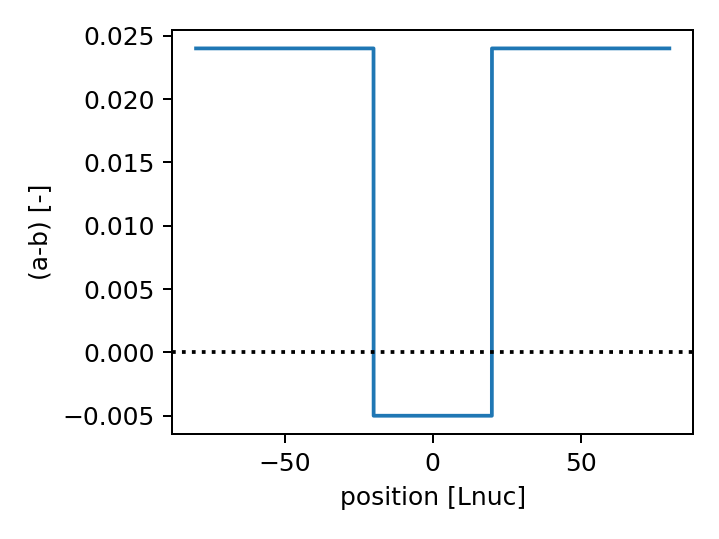

In [3]:
plt.figure(figsize=(4,3))
plt.plot(x/Lc, p.mesh_dict["A"] - p.mesh_dict["B"])
plt.axhline(0, ls=":", c="k")
plt.xlabel("position [Lnuc]")
plt.ylabel("(a-b) [-]")
plt.tight_layout()
# plt.savefig("asperity_a-b.png")
plt.show()

# Quick check of simulation outputs

In [4]:
### POST-PROCESS ###
p.read_output(read_ox=False, read_ox_dyn=True)


True

<IPython.core.display.Javascript object>


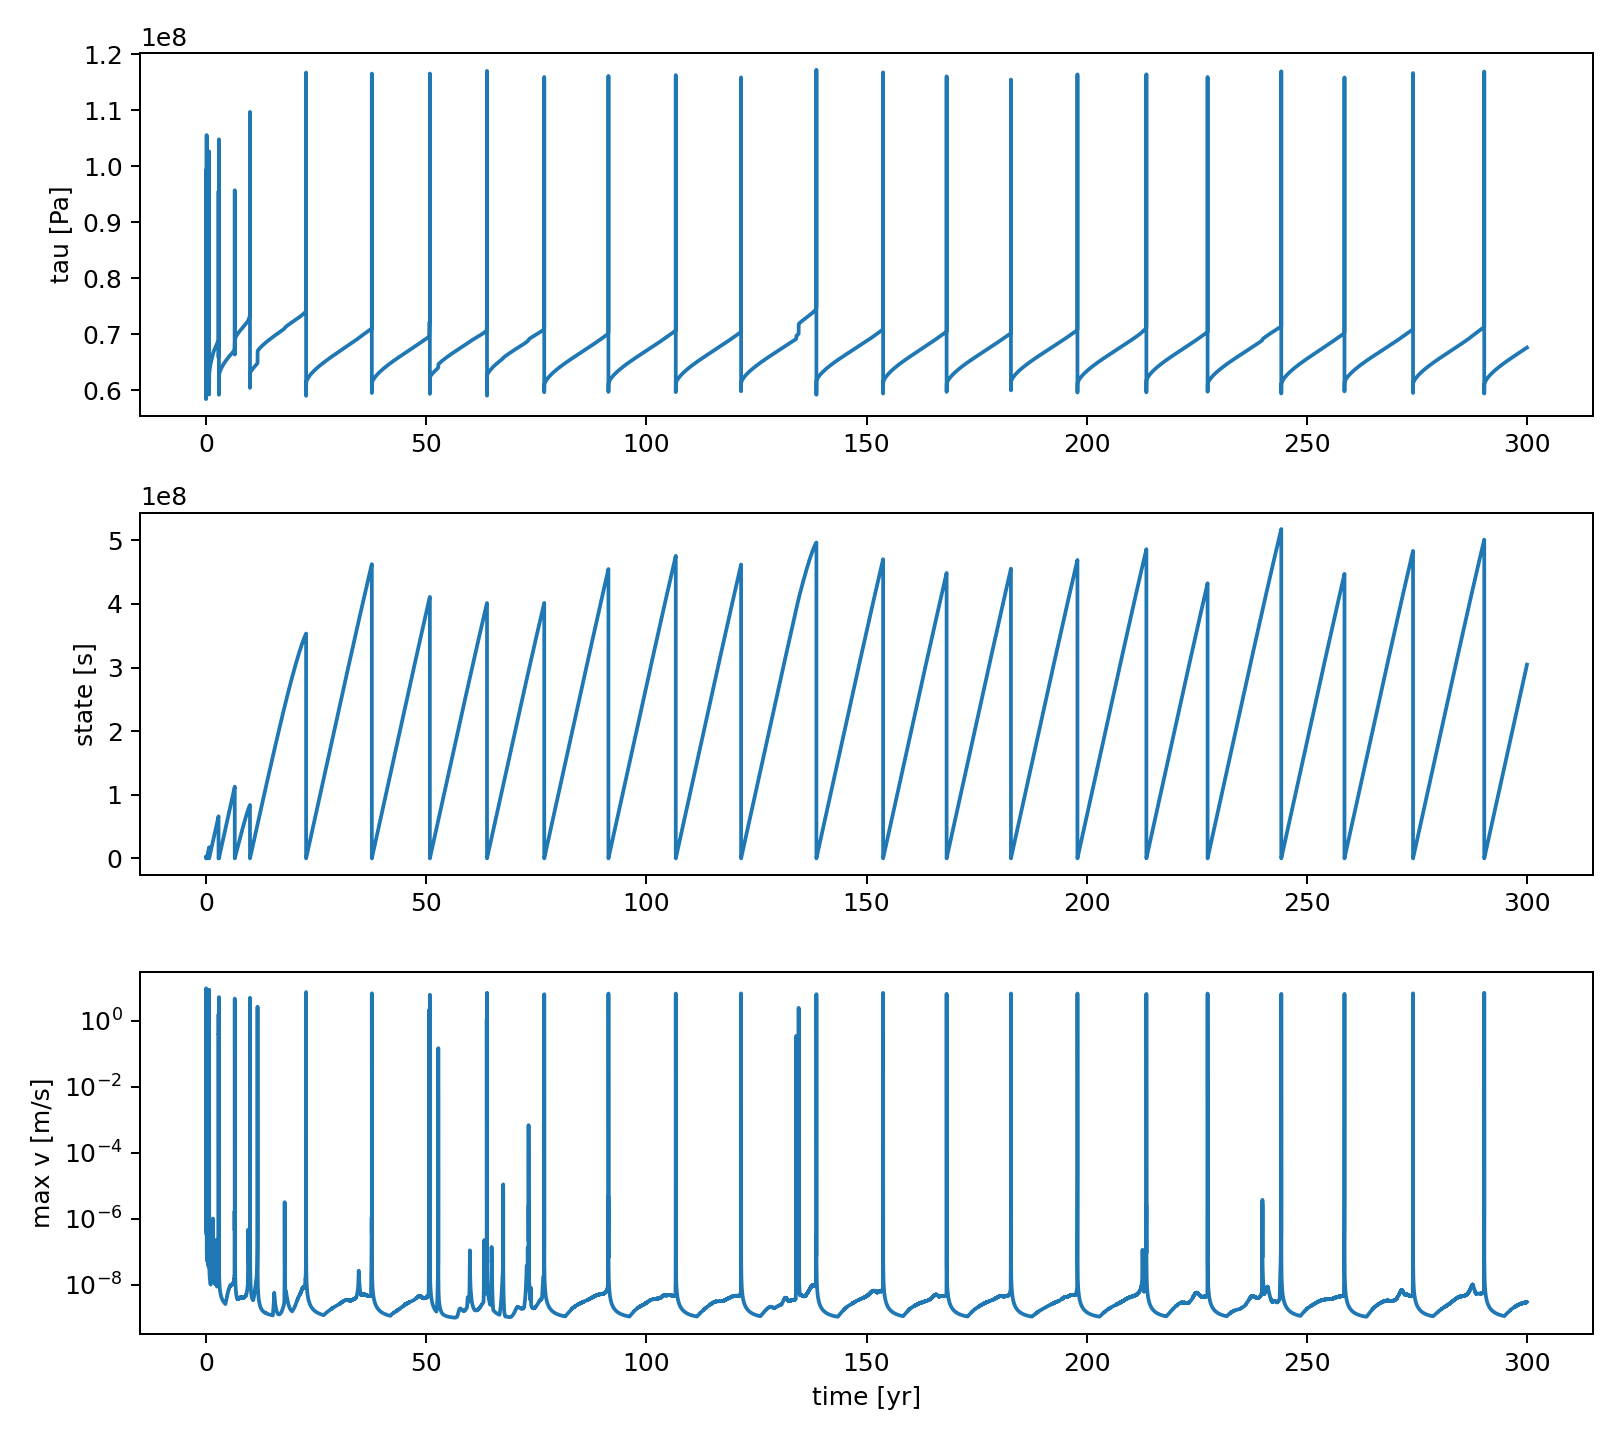

In [5]:
# Time series of stress, state, and maximum slip rate on the fault
qdyn_plot.timeseries(p.ot[0], p.ot_vmax)

# Read dyn files

In [6]:
# ox_dyn_files_rup = np.array([file for file in os.listdir(".") if file.startswith("output_dyn_max")])
# ox_dyn_files_rup

In [10]:
# data_ox_dyn_rup = [None] * len(ox_dyn_files_rup)
# quants_rup = ("x", "y", "z", "t", "tau_max", "t_v_max", "v_max")

In [7]:
# import pandas as pd
# from pandas import read_csv
# for i in range(len(ox_dyn_files_rup)):
#                 # Rupture stats file
#                 data_ox_dyn_rup[i] = read_csv(
#                     ox_dyn_files_rup[i], header=None, names=quants_rup,
#                     delim_whitespace=True, comment="#"
#                 )
#                 # Sanitise output (check for near-infinite numbers, etc.)
#                 data_ox_dyn_rup[i] = data_ox_dyn_rup[i].apply(pd.to_numeric, errors="coerce")    

In [8]:
# p.ox_dyn_rup = data_ox_dyn_rup 

In [9]:
# dum = (p.ox_dyn_rup[-1])
# plt.plot( np.log10(dum['v_max']), dum['x'])

# Read 2D ox files (after chunking)
* Output file (ox) was ~ 250G for this simulation of 300 yrs. I had to split files into chunks where each CHUNKSIZE=1e8. See file for splitting in "/qdyn-read-only/examples/elif/40L_homogeneous/split_ox_chunks2.py"

### Events after t~274 yr

In [3]:
%%time

# READ ONLY CHUNK FILE of OX
filename = './ox_chunks/output_ox_chunk_13'

quants_ox = ("t", "x", "y", "z", "v", "theta", "tau", "tau_dot", "slip", "sigma")
dum = pd.read_csv(filename, header=None, names=quants_ox, delim_whitespace=True, comment="#")
dum

CPU times: user 1min 11s, sys: 14.5 s, total: 1min 26s
Wall time: 1min 30s


,t,x,y,z,v,theta,tau,tau_dot,slip,sigma
1300000000,8.644902e+09,786.343542,0.0,0.0,6.731966e-10,3090155.0,70950060.0,0.0,14.068760,120000000.0
1300000001,8.644902e+09,786.579787,0.0,0.0,6.732696e-10,3089701.0,70950290.0,0.0,14.068690,120000000.0
1300000002,8.644902e+09,786.816033,0.0,0.0,6.733425e-10,3089248.0,70950510.0,0.0,14.068610,120000000.0
1300000003,8.644902e+09,787.052279,0.0,0.0,6.734155e-10,3088795.0,70950740.0,0.0,14.068540,120000000.0
1300000004,8.644902e+09,787.288524,0.0,0.0,6.734884e-10,3088343.0,70950960.0,0.0,14.068470,120000000.0
...,...,...,...,...,...,...,...,...,...,...
1369849851,9.460879e+09,1934.261003,0.0,0.0,9.877189e-10,2024565.0,71964070.0,0.0,10.098700,120000000.0
1369849852,9.460879e+09,1934.497248,0.0,0.0,9.890252e-10,2021925.0,71967920.0,0.0,10.029700,120000000.0
1369849853,9.460879e+09,1934.733494,0.0,0.0,9.905914e-10,2018768.0,71972520.0,0.0,9.947491,120000000.0
1369849854,9.460879e+09,1934.969740,0.0,0.0,9.924340e-10,2015066.0,71977920.0,0.0,9.851269,120000000.0


8644901626.0864 9460878866.2906
data_shape (Nt, Nx): (4263, 16384)
(4263, 16384) (4263, 16384) (4263, 16384)
vmin, vmax:  0 0.1


<IPython.core.display.Javascript object>


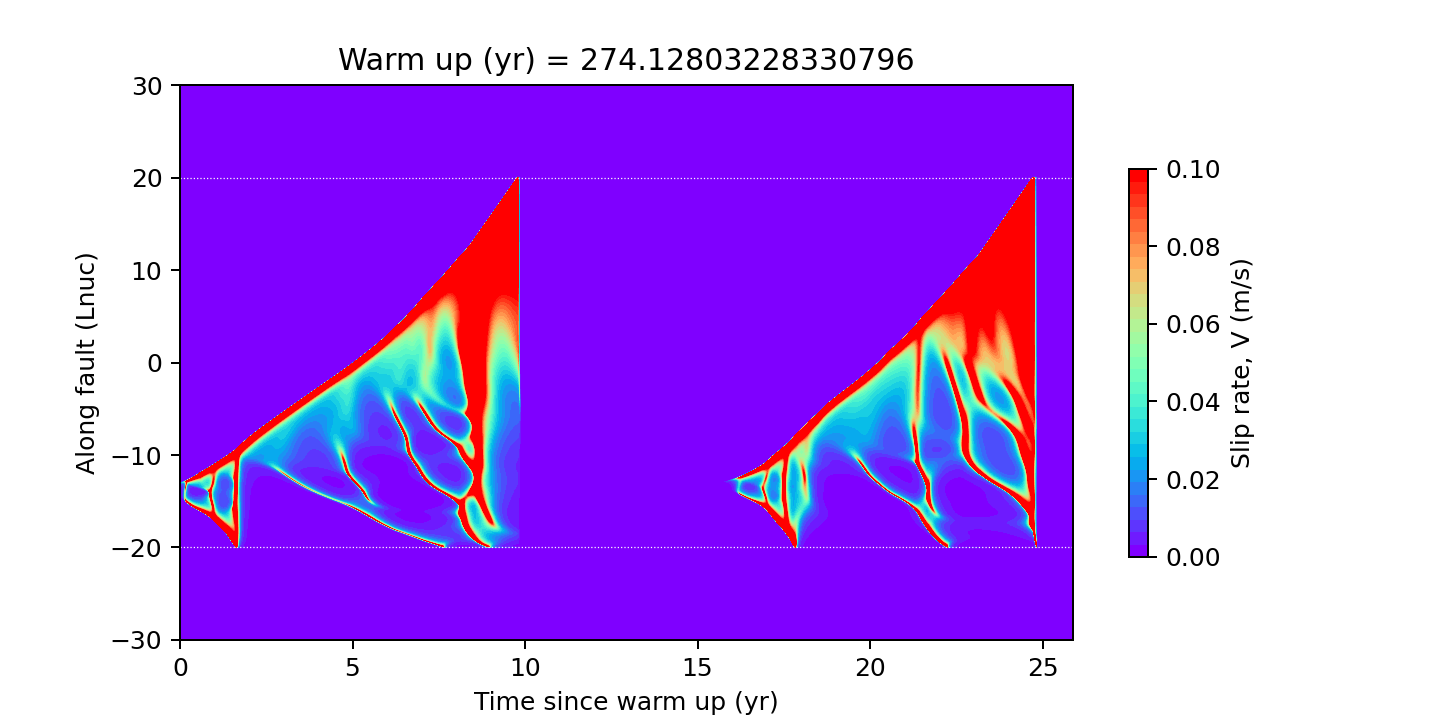

In [4]:
t_beg, t_end = dum['t'].values[0], dum['t'].values[-1]

# for quick visual comparison with fully-dynamic results, avoid normlization
qdyn_plot.plot_2D_slip_rate(dum,t_beg=t_beg, t_end=t_end,V_pl=1e-9,Lvw=20,Lc=Lc,
                          normalize=False,cmap='rainbow',vmin=0,vmax=0.1, is_log=False)

8644901626.0864 9460878866.2906
data_shape (Nt, Nx): (4263, 16384)
(4263, 16384) (4263, 16384) (4263, 16384)
vmin, vmax:  -4.380396151545664 9.845750356522906


<IPython.core.display.Javascript object>


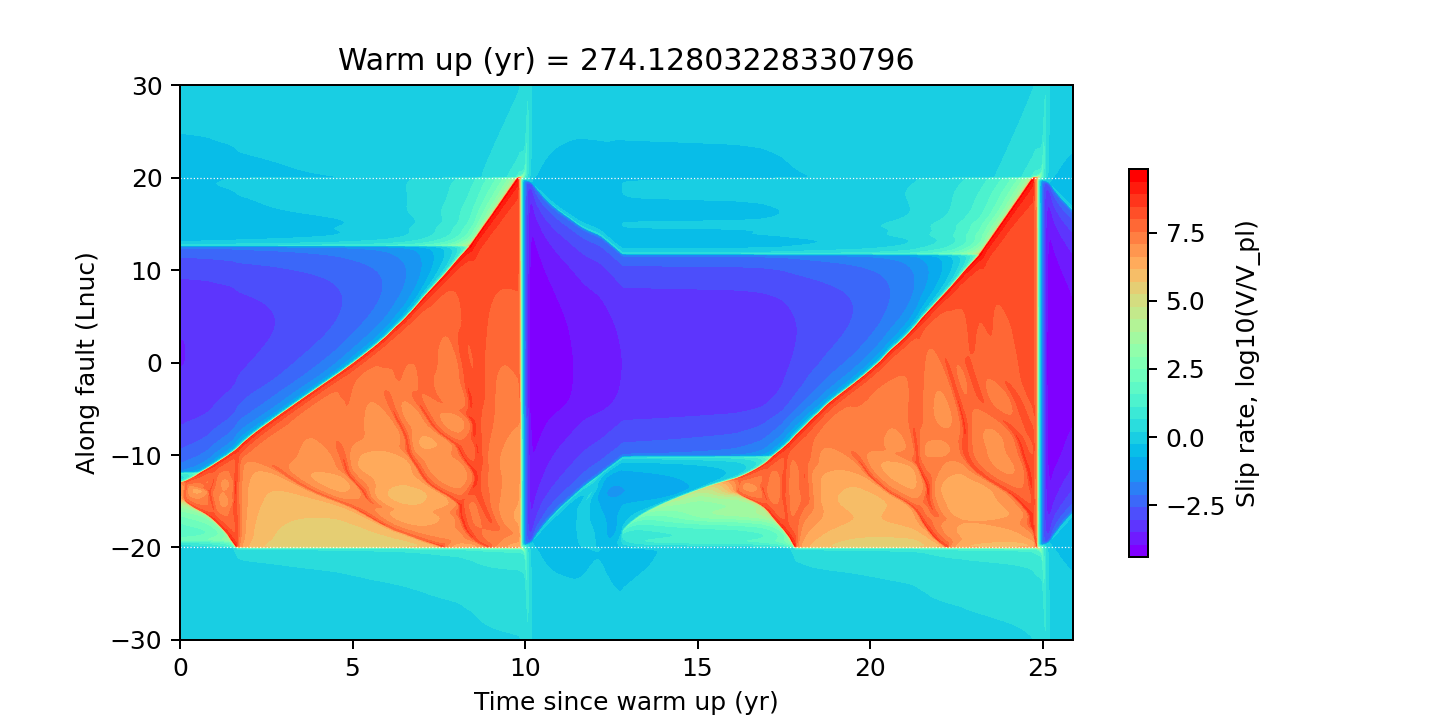

In [11]:
qdyn_plot.plot_2D_slip_rate(dum,t_beg=t_beg, t_end=t_end,V_pl=1e-9,Lvw=20,Lc=Lc,cmap='rainbow')

## Events after t~244 yrs

In [18]:
%%time

# READ ONLY CHUNK FILE of OX
filename = './ox_chunks/output_ox_chunk_12'

quants_ox = ("t", "x", "y", "z", "v", "theta", "tau", "tau_dot", "slip", "sigma")
dum = pd.read_csv(filename, header=None, names=quants_ox, delim_whitespace=True, comment="#")
# dum

CPU times: user 1min 47s, sys: 34 s, total: 2min 21s
Wall time: 2min 43s


7695106348.6293 8644901626.0864
data_shape (Nt, Nx): (6103, 16384)
(6103, 16384) (6103, 16384) (6103, 16384)
vmin, vmax:  -4.372087624630618 9.817086985635779


<IPython.core.display.Javascript object>


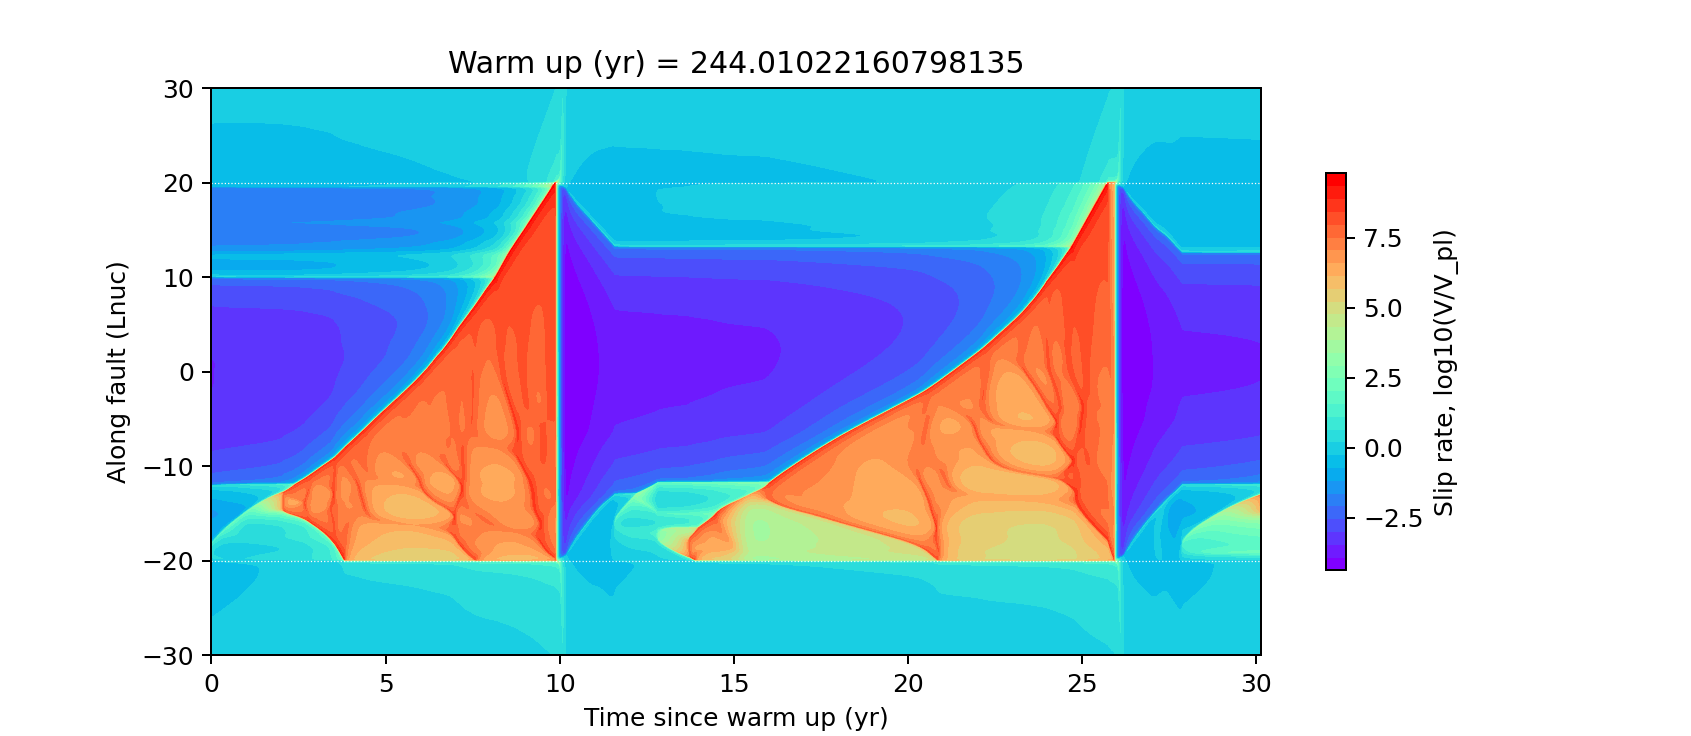

In [19]:
t_beg, t_end = dum['t'].values[0], dum['t'].values[-1]
qdyn_plot.plot_2D_slip_rate(dum,t_beg=t_beg, t_end=t_end,V_pl=1e-9,Lvw=20,Lc=Lc,cmap='rainbow')

## Events after t~212 yrs

In [20]:
%%time

# READ ONLY CHUNK FILE of OX
filename = './ox_chunks/output_ox_chunk_11'

quants_ox = ("t", "x", "y", "z", "v", "theta", "tau", "tau_dot", "slip", "sigma")
dum = pd.read_csv(filename, header=None, names=quants_ox, delim_whitespace=True, comment="#")
# dum

CPU times: user 1min 50s, sys: 34.2 s, total: 2min 25s
Wall time: 3min 43s


6709814273.7902 7694991126.9474
data_shape (Nt, Nx): (6103, 16384)
(6103, 16384) (6103, 16384) (6103, 16384)
vmin, vmax:  -4.411695568200011 9.824213465310656


<IPython.core.display.Javascript object>


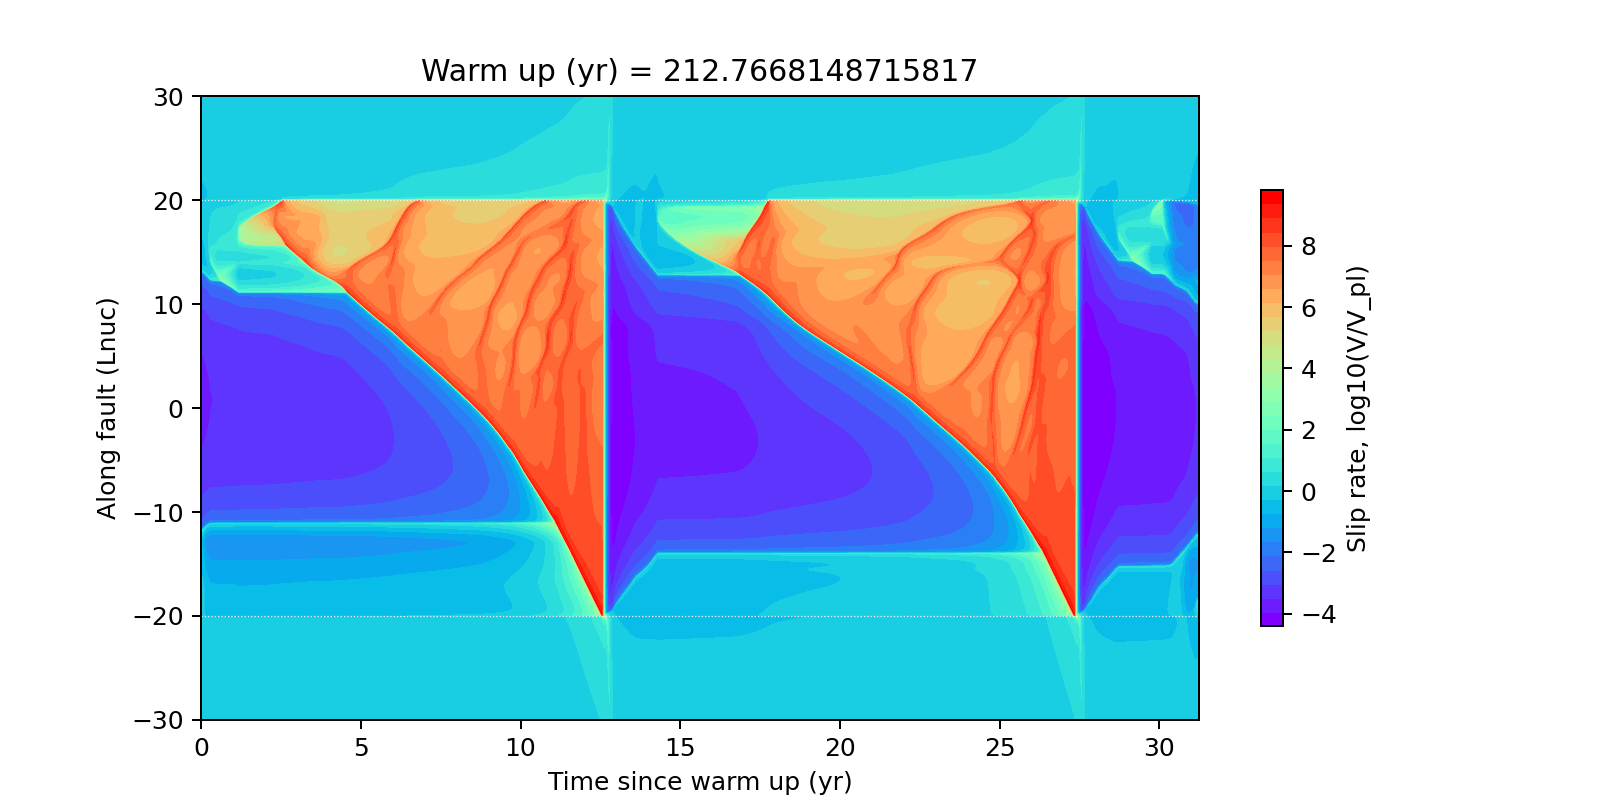

In [21]:
# some chunks may be incomplete for the first or last step; so slicing btw t_vals[1] and t_vals[-2]
t_beg, t_end = list(dum['t'].unique())[0], list(dum['t'].unique())[-2]
qdyn_plot.plot_2D_slip_rate(dum,t_beg=t_beg, t_end=t_end,V_pl=1e-9,Lvw=20,Lc=Lc,cmap='rainbow')

In [ ]:
#fin